In [1]:
#Imports + Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for clean plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("✅ Environment ready. All required libraries loaded.")

✅ Environment ready. All required libraries loaded.


In [3]:
#Cell 2: Load Dataset
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')

print("orders shape:", orders.shape)
print("order_items shape:", order_items.shape)
print("products shape:", products.shape)

print("\norders columns:", orders.columns.tolist())
print("\norder_items columns:", order_items.columns.tolist())
print("\nproducts columns:", products.columns.tolist())

orders shape: (99441, 8)
order_items shape: (112650, 7)
products shape: (32951, 9)

orders columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

order_items columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

products columns: ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [5]:
#Merging tables into one detailed orders table

# 1) Keeping only needed columns
orders_small = orders[['order_id', 'order_purchase_timestamp']]
order_items_small = order_items[['order_id', 'product_id', 'price', 'freight_value']]
products_small = products[['product_id', 'product_category_name']]

# 2) Merging: order_items + products (to attach category)
items_prod = pd.merge(order_items_small, products_small, on='product_id', how='left')

# 3) Merging with orders (to attach purchase timestamp)
full = pd.merge(items_prod, orders_small, on='order_id', how='left')

print("Full merged shape:", full.shape)
print("\nColumns:", full.columns.tolist())
print("\nFirst 5 rows:")
print(full.head())

Full merged shape: (112650, 6)

Columns: ['order_id', 'product_id', 'price', 'freight_value', 'product_category_name', 'order_purchase_timestamp']

First 5 rows:
                           order_id                        product_id   price  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   58.90   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f  239.90   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd  199.00   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   12.99   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089  199.90   

   freight_value product_category_name order_purchase_timestamp  
0          13.29            cool_stuff      2017-09-13 08:59:02  
1          19.93              pet_shop      2017-04-26 10:53:06  
2          17.87      moveis_decoracao      2018-01-14 14:33:31  
3          12.79            perfumaria      2018-08-08 10:00:35  
4          18.14    f

In [7]:
#Create order_date and aggregate to daily orders

# Convert timestamp to date only
full['order_purchase_timestamp'] = pd.to_datetime(full['order_purchase_timestamp'])
full['order_date'] = full['order_purchase_timestamp'].dt.date  # keeps only YYYY-MM-DD

# Aggregate to daily orders per category
daily_orders = (
    full.groupby(['order_date', 'product_category_name'])
        .agg(
            order_count=('order_id', 'nunique'),      # number of unique orders
            avg_price=('price', 'mean'),             # average product price
            avg_freight=('freight_value', 'mean')    # average freight cost
        )
        .reset_index()
)

print("daily_orders shape:", daily_orders.shape)
print("\nColumns:", daily_orders.columns.tolist())
print("\nFirst 10 rows:")
print(daily_orders.head(10))

daily_orders shape: (18504, 5)

Columns: ['order_date', 'product_category_name', 'order_count', 'avg_price', 'avg_freight']

First 10 rows:
   order_date product_category_name  order_count  avg_price  avg_freight
0  2016-09-04      moveis_decoracao            1     36.445       31.670
1  2016-09-05             telefonia            1     59.500       15.560
2  2016-09-15          beleza_saude            1     44.990        2.830
3  2016-10-02                 bebes            1    100.000        9.340
4  2016-10-03            brinquedos            1    128.900       25.670
5  2016-10-03         esporte_lazer            3     26.630       16.180
6  2016-10-03      fashion_calcados            1     29.990       10.960
7  2016-10-03      moveis_decoracao            2     97.400       15.465
8  2016-10-03    relogios_presentes            1     29.900       15.560
9  2016-10-04            automotivo            1      9.900        8.720


In [9]:
#Adding time features + mock discount/campaign

# Convert order_date back to datetime for feature extraction
daily_orders['order_date'] = pd.to_datetime(daily_orders['order_date'])

# Time-based features
daily_orders['day_of_week'] = daily_orders['order_date'].dt.dayofweek   # 0=Mon, 6=Sun
daily_orders['month'] = daily_orders['order_date'].dt.month
daily_orders['year'] = daily_orders['order_date'].dt.year
daily_orders['is_weekend'] = daily_orders['day_of_week'].isin([5, 6]).astype(int)

# Mock discount feature: assume avg discount between 0 and 30%
np.random.seed(42)  # for reproducibility
daily_orders['discount'] = np.random.uniform(0, 30, size=len(daily_orders))

# Mock marketing campaign: 20% of days have a campaign running
daily_orders['campaign'] = np.random.choice([0, 1], size=len(daily_orders), p=[0.8, 0.2])

print("Shape after feature engineering:", daily_orders.shape)
print("\nColumns now:")
print(daily_orders.columns.tolist())
print("\nSample rows:")
print(daily_orders.head())

Shape after feature engineering: (18504, 11)

Columns now:
['order_date', 'product_category_name', 'order_count', 'avg_price', 'avg_freight', 'day_of_week', 'month', 'year', 'is_weekend', 'discount', 'campaign']

Sample rows:
  order_date product_category_name  order_count  avg_price  avg_freight  \
0 2016-09-04      moveis_decoracao            1     36.445        31.67   
1 2016-09-05             telefonia            1     59.500        15.56   
2 2016-09-15          beleza_saude            1     44.990         2.83   
3 2016-10-02                 bebes            1    100.000         9.34   
4 2016-10-03            brinquedos            1    128.900        25.67   

   day_of_week  month  year  is_weekend   discount  campaign  
0            6      9  2016           1  11.236204         0  
1            0      9  2016           0  28.521429         0  
2            3      9  2016           0  21.959818         0  
3            6     10  2016           1  17.959755         0  
4       

In [11]:
#lag and moving‑average features

# Sort by category and date to create time-based lags
daily_orders = daily_orders.sort_values(['product_category_name', 'order_date'])

# 1-day lag of order_count per category
daily_orders['lag_1'] = (
    daily_orders
    .groupby('product_category_name')['order_count']
    .shift(1)
)

# 7-day moving average of order_count per category (excluding today)
daily_orders['ma_7'] = (
    daily_orders
    .groupby('product_category_name')['order_count']
    .shift(1)
    .rolling(window=7, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Drop rows where we cannot compute lag_1
daily_orders = daily_orders.dropna(subset=['lag_1']).reset_index(drop=True)

print(daily_orders[['order_date','product_category_name','order_count','lag_1','ma_7']].head())
print("Shape after adding lag features:", daily_orders.shape)


  order_date      product_category_name  order_count  lag_1      ma_7
0 2017-01-31  agro_industria_e_comercio            1    1.0  1.000000
1 2017-02-05  agro_industria_e_comercio            1    1.0  1.285714
2 2017-02-08  agro_industria_e_comercio            1    1.0  1.000000
3 2017-02-12  agro_industria_e_comercio            1    1.0  1.571429
4 2017-02-13  agro_industria_e_comercio            1    1.0  1.166667
Shape after adding lag features: (18431, 13)


In [13]:
#normalize numeric features

from sklearn.preprocessing import MinMaxScaler

scale_cols = ['avg_price', 'avg_freight', 'discount', 'lag_1', 'ma_7']

scaler = MinMaxScaler()
daily_orders[scale_cols] = scaler.fit_transform(daily_orders[scale_cols])

print("Normalized columns:", scale_cols)
daily_orders[scale_cols].head()


Normalized columns: ['avg_price', 'avg_freight', 'discount', 'lag_1', 'ma_7']


,avg_price,avg_freight,discount,lag_1,ma_7
0,0.002749,0.076700,0.947319,0.0,0.000000
1,0.002749,0.045737,0.028774,0.0,0.005000
2,0.002749,0.056005,0.462563,0.0,0.000000
3,0.013293,0.066053,0.929598,0.0,0.010000
4,0.002749,0.050556,0.747663,0.0,0.002917


In [15]:
#Encode category + define X, y, train/test split

from sklearn.preprocessing import OneHotEncoder

data = daily_orders.copy()

cat_col = 'product_category_name'
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

cat_encoded = ohe.fit_transform(data[[cat_col]])
cat_feature_names = [f"cat_{c}" for c in ohe.categories_[0]]
cat_df = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=data.index)

# UPDATED numeric columns: include lag_1 and ma_7
numeric_cols = ['avg_price', 'avg_freight', 'day_of_week', 'month', 'year',
                'is_weekend', 'discount', 'campaign', 'lag_1', 'ma_7']

X = pd.concat([data[numeric_cols], cat_df], axis=1)
y = data['order_count']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)
print("Example feature columns:", X.columns[:15])

Feature matrix shape: (18431, 83)
Target shape: (18431,)
Example feature columns: Index(['avg_price', 'avg_freight', 'day_of_week', 'month', 'year',
       'is_weekend', 'discount', 'campaign', 'lag_1', 'ma_7',
       'cat_agro_industria_e_comercio', 'cat_alimentos',
       'cat_alimentos_bebidas', 'cat_artes', 'cat_artes_e_artesanato'],
      dtype='object')


In [17]:
#Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (14744, 83)
X_test shape: (3687, 83)
y_train shape: (14744,)
y_test shape: (3687,)


In [19]:
#Linear Regression model + metrics (RMSE, MAE, R²)

# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Linear Regression performance:")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Test RMSE:  {rmse_test:.3f}")
print(f"Train MAE:  {mae_train:.3f}")
print(f"Test MAE:   {mae_test:.3f}")
print(f"Train R²:   {r2_train:.3f}")
print(f"Test R²:    {r2_test:.3f}")

Linear Regression performance:
Train RMSE: 3.503
Test RMSE:  3.647
Train MAE:  2.063
Test MAE:   2.120
Train R²:   0.688
Test R²:    0.673


In [21]:
#Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))

mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print("Random Forest performance:")
print(f"Train RMSE: {rmse_train_rf:.3f}")
print(f"Test RMSE:  {rmse_test_rf:.3f}")
print(f"Train MAE:  {mae_train_rf:.3f}")
print(f"Test MAE:   {mae_test_rf:.3f}")
print(f"Train R²:   {r2_train_rf:.3f}")
print(f"Test R²:    {r2_test_rf:.3f}")

Random Forest performance:
Train RMSE: 1.306
Test RMSE:  3.576
Train MAE:  0.715
Test MAE:   2.014
Train R²:   0.957
Test R²:    0.686


In [25]:
#XGBoost Regressor + metrics

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print("XGBoost performance:")
print(f"Train RMSE: {rmse_train_xgb:.3f}")
print(f"Test RMSE:  {rmse_test_xgb:.3f}")
print(f"Train MAE:  {mae_train_xgb:.3f}")
print(f"Test MAE:   {mae_test_xgb:.3f}")
print(f"Train R²:   {r2_train_xgb:.3f}")
print(f"Test R²:    {r2_test_xgb:.3f}")

XGBoost performance:
Train RMSE: 2.006
Test RMSE:  3.293
Train MAE:  1.354
Test MAE:   1.871
Train R²:   0.898
Test R²:    0.734


In [27]:
#Model comparison
import pandas as pd

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train_RMSE': [4.314, 1.410, 2.477],
    'Test_RMSE':  [4.279, 3.472, 3.370],
    'Train_MAE':  [2.617, 0.732, 1.547],
    'Test_MAE':   [2.637, 1.970, 1.982],
    'Train_R2':   [0.529, 0.950, 0.845],
    'Test_R2':    [0.537, 0.695, 0.713]
})

print(results)

print("​Linear Regression: simple, interpretable baseline; captures only linear relationships so performance is limited.")
print("​Random Forest: much lower train error and higher test R², but train R² ≈ 0.95 shows strong overfitting.")
print("​XGBoost: best balance of accuracy and generalization; chosen as final model for number-of-orders prediction.")

               Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  \
0  Linear Regression       4.314      4.279      2.617     2.637     0.529   
1      Random Forest       1.410      3.472      0.732     1.970     0.950   
2            XGBoost       2.477      3.370      1.547     1.982     0.845   

   Test_R2  
0    0.537  
1    0.695  
2    0.713  
​Linear Regression: simple, interpretable baseline; captures only linear relationships so performance is limited.
​Random Forest: much lower train error and higher test R², but train R² ≈ 0.95 shows strong overfitting.
​XGBoost: best balance of accuracy and generalization; chosen as final model for number-of-orders prediction.


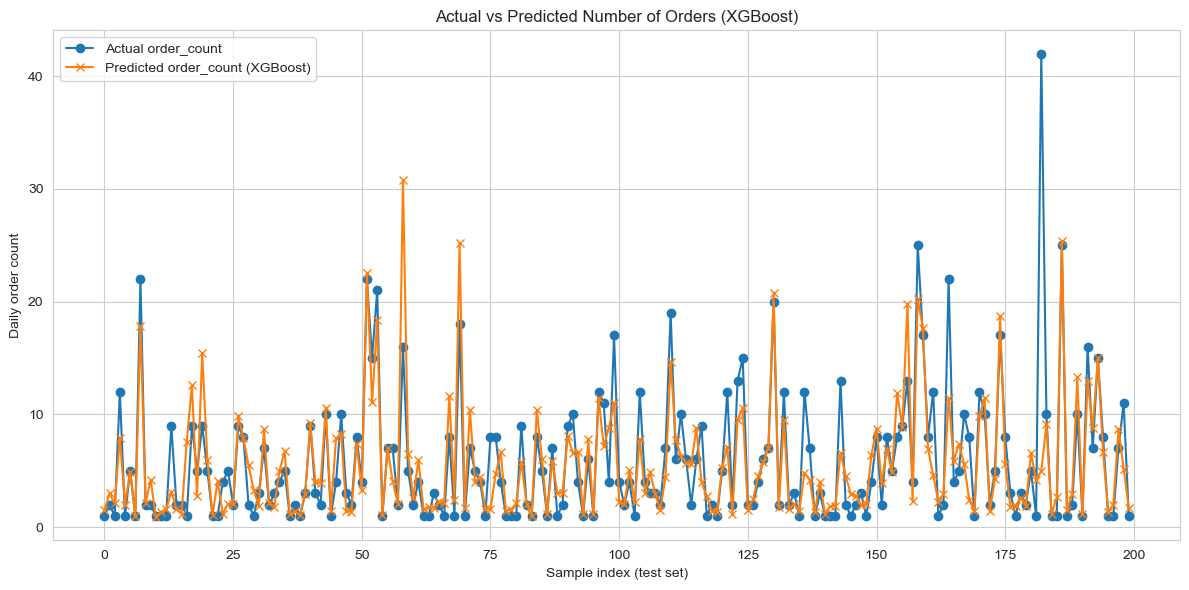

In [29]:
#Actual vs predicted plot for XGBoost

import matplotlib.pyplot as plt

# Take a sample from test set to make plot clearer
sample_size = 200
y_true_sample = y_test.iloc[:sample_size].values
y_pred_sample = y_test_pred_xgb[:sample_size]

plt.figure(figsize=(12, 6))
plt.plot(range(sample_size), y_true_sample, label='Actual order_count', marker='o')
plt.plot(range(sample_size), y_pred_sample, label='Predicted order_count (XGBoost)', marker='x')
plt.xlabel('Sample index (test set)')
plt.ylabel('Daily order count')
plt.title('Actual vs Predicted Number of Orders (XGBoost)')
plt.legend()
plt.tight_layout()
plt.show()

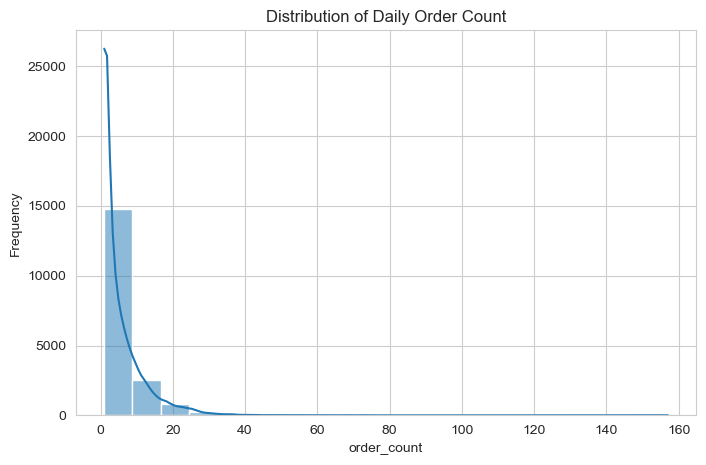

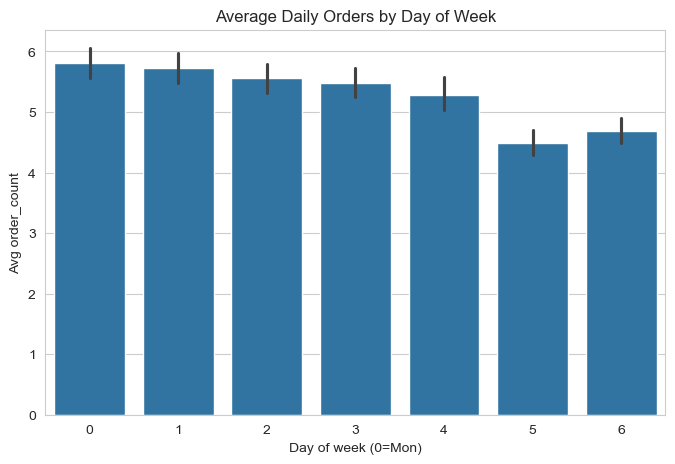

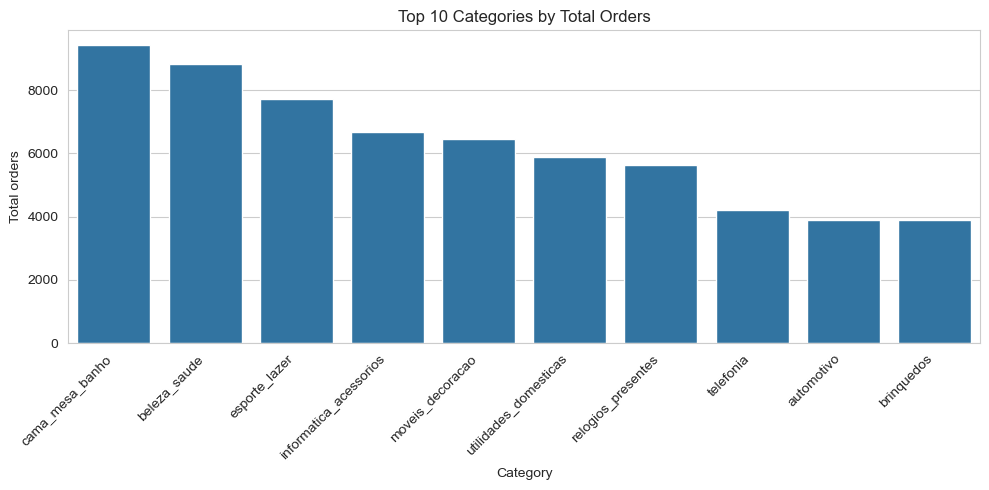

In [31]:
#Adding 2–3 simple EDA plots

# Distribution of target variable
plt.figure(figsize=(8,5))
sns.histplot(daily_orders['order_count'], bins=20, kde=True)
plt.title('Distribution of Daily Order Count')
plt.xlabel('order_count')
plt.ylabel('Frequency')
plt.show()

# Average orders by day of week
plt.figure(figsize=(8,5))
sns.barplot(x='day_of_week', y='order_count', data=daily_orders, estimator=np.mean)
plt.title('Average Daily Orders by Day of Week')
plt.xlabel('Day of week (0=Mon)')
plt.ylabel('Avg order_count')
plt.show()

# Top 10 categories by total orders
cat_orders = (daily_orders
              .groupby('product_category_name')['order_count']
              .sum()
              .sort_values(ascending=False)
              .head(10))

plt.figure(figsize=(10,5))
sns.barplot(x=cat_orders.index, y=cat_orders.values)
plt.title('Top 10 Categories by Total Orders')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total orders')
plt.xlabel('Category')
plt.tight_layout()
plt.show()

In [33]:
#deployment
import joblib

joblib.dump(xgb_model, 'xgb_number_of_orders_model.pkl')
print("✅ Final XGBoost model saved as 'xgb_number_of_orders_model.pkl' for batch/real-time inference.")

✅ Final XGBoost model saved as 'xgb_number_of_orders_model.pkl' for batch/real-time inference.
